In [53]:
import pandas as pd
import numpy as np
import pickle

#### Loading Dataset
Dataset source: https://www.kaggle.com/datasets/skillsmuggler/amazon-ratings

In [3]:
dataset = pd.read_csv("dataset/user-product-rating.csv")

#### Dataset Description
The dataset contains 2 million beauty related products reviews from Amazon.com, a popular electronic commerce website.

- UserId: Customer Identification
- ProductId: Product ASIN (Amazon's unique product identification code for each product)
- Ratings: rating ranging from 1-5 based on customer satisfaction
- Timestamp: time when the rating is submitted (in UNIX time)

In [4]:
dataset.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [ ]:
for col in dataset.columns:
    null_value = dataset[col].isnull().sum()
    if null_value > 0:
        print(f"{null_value} missing value(s) in {col} column.")
    else:
        print(f"No missing value in {col} column.")

No missing value in UserId column.
No missing value in ProductId column.
No missing value in Rating column.
No missing value in Timestamp column.


In [10]:
print(f"The dataset contains {dataset.shape[0]} rows of data.")

The dataset contains 2023070 rows of data.


In [13]:
# User
print(f"... User Statistics ...")
print(f"Unique users: {dataset['UserId'].nunique()}")
print(f"User maximum frequency: {dataset['UserId'].value_counts().max()}")
print(f"User minimum frequency: {dataset['UserId'].value_counts().min()}")


... User Statistics ...
Unique users: 1210271
User maximum frequency: 389
User minimum frequency: 1


In [14]:
# Product
print(f"... Product Statistics ...")
print(f"Unique prducts: {dataset['ProductId'].nunique()}")
print(f"Product maximum frequency: {dataset['ProductId'].value_counts().max()}")
print(f"Product minimum frequency: {dataset['ProductId'].value_counts().min()}")


... Product Statistics ...
Unique prducts: 249274
Product maximum frequency: 7533
Product minimum frequency: 1


In [17]:
dataset = dataset.drop(columns='Timestamp')

# Convert UserId and ProductId from str to int
dataset['UserId'] = dataset['UserId'].astype('category').cat.codes
dataset['ProductId'] = dataset['ProductId'].astype('category').cat.codes

In [18]:
dataset.head()

,UserId,ProductId,Rating
0,725046,0,5.0
1,814606,1,3.0
2,313101,1,5.0
3,291075,2,4.0
4,802842,3,1.0


### Collaborative Filtering
References: 
- https://github.com/Balajirvp/Recommender-Systems---Content-Based-Systems-and-Collaborative-Filtering/blob/main/Recommender%20Systems%20-%20Content%20Based%20Systems%20and%20Collaborative%20Filtering.ipynb

- https://developers.google.com/machine-learning/recommendation/collaborative/matrix

We will explore collaborative filtering that leverages statistical concept or machine learning algorithms to learn latent representations (embeddings) for both users and products. These embeddings capture hidden patterns in user preferences and item characteristics implicitly, without having to do feature engineering to extract the relevant features that best describe the products like in content-based filtering approach.

A common approach for collaborative filtering is matrix factorization, where the user-item interaction matrix, usually ratings is decomposed into two lower-dimensional matrices: one for users and one for items. The dot product of these embeddings gives a predicted score like user's rating for a product. Yet, other than matrix factorization technique, there are algortihms that use mathematical theory on similarity or correlation, normal distribution parameters, distribution mean and so on to come out with predicted ratings.

In this section, we use the Surprise package to explore various collaborative filtering algorithms:

In [19]:
from surprise import Reader, Dataset
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import cross_validate

<!-- Data Preparation using Reader -->
Before feeding data into the model, the data needs to be wrapped using Surprise's <mark>Reader</mark> class. The <mark>Reader</mark> defines the format of the dataset and rating scale (score 1 to 5 in our case). It tells the model framework how to interpret the input data.

<mark>cross_validate()</mark> from Surprise is also used to perform the typical k-fold cross validation steps for training and testing process. The tool splits the dataset into training and test sets across multiple folds. This ensures that all data points are eventually used for testing. 

The evaluation results of RMSE and MAE are recorded while the trained model are saved in the later part.

In [20]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(dataset, reader)

1. SVD (Singular Value Decomposition)

SVD is a mathematical technique to decompose the real-valued matrix $R$ into three separate matrices: $$ R = U\Sigma V^T$$ 
Where 
- $R$: Original $m \times n$ matrix
- $U$: $m \times m$ orthogonal matrix (satisfy $U^T U = I$) whose columns are the left singular vectors of $R$
- $\Sigma$: $m \times n$ diagonal matrix with non-negative real numbers on the diagonal
- $V^T$: Transpose of an $n \times n$ orthogonal matrix $V$, whose columns are the right singular vectors of $R$

There is a series of steps to compute SVD: 
\
<sub>(Refer https://www.geeksforgeeks.org/singular-value-decomposition-svd/ for demo)</sub>
- Compute $R^T R$ and $R R^T$
    - Get eigenvectors of $R^T R$ to form matrix $V$ (Left singular vectors)
    - Get eigenvectors of $R R^T$ to form matrix $U$ (Right singular vectors)
    - Get square roots of the eigenvalues of $R^T R$ or $R R^T$ to form the singular values (diagnal elements in $\Sigma$)

\
Classical SVD requires a **fully filled matrix** and is computationally expensive for large, sparse datasets. The SVD in surprise package or SVD used for collaborative filtering is not computing the full decomposition using eigenvalue methods. Instead, it performs an approximate low-rank factorization of the user-item matrix by learning latent vectors for users and items. 

1. Truncated SVD keeps only the top $k$ singular values and corresponding singular vectors, giving an approximation of reduced matrices:
$$ R \approx U_k\Sigma_k V_k^T$$ 

2. Absorbing $\Sigma$ into $U$
Given equation in (1), 
$$\hat{r}_{ui} = \Sigma_{k} u_{uk}s_{kk}v_{ki} = \Sigma_{k} (u_{uk} s_{kk}) v_{ki} = \Sigma_{k} u^\prime_{uk}v_{ki} = (u^\prime_u)^T v_i$$

Let vectors $u^\prime_u = p_u$ and $v_i = q_i$,
$$\hat{r}_{ui} = p_u^T q_i$$
$p_u^T q_i$ here refers to the dot product representing the approximate (since the dimension is being reduced when extracting the user and item latent features) interaction between user and item features.

3. Adding in biases and global average
$$\hat{r}_{ui} = \mu + b_u + b_i + p_u^T q_i$$
Where:
- $\mu$: Global average rating
- $b_u$: Bias of user $u$ (how much higher/lower the user tends to rate)
- $b_i$: Bias of item $i$ (how much more popular the item is)

The equation in (3) is the prediction function. To learn the values inside the prediction function, **Stochastic Gradient Descent (SGD)** is used to minimize the loss:

$$Loss = \Sigma_{(u,i)\in known} (r_{ui} - \hat{r}_{ui})^2 + \lambda (\|p_u\|^2 + \|q_i\|^2 + b_u^2 + b_i^2)$$

Where
- $r_{ui}$: Actual rating
- $\|p_u\|^2$ and $\|q_i\|^2$: Regularization on user and item latent vectors
- $ b_u^2$ and $b_i^2$: Regularization on user and item biases
- $\lambda$: Regularization strength

In [21]:
algorithm_svd = SVD()
results_svd = cross_validate(algorithm_svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=False) 

2. SVDpp (SVD++)

SVD++ is an extension of SVD that takes into account the implicit feedback(ratings in our case) for better accuracy.

$$\hat{r}_{ui} = \mu + b_u + b_i + p_u^T (q_i + |I_i|^{-\frac{1}{2}} \Sigma_{j \in I_i} y_j$$

Where $y_j$ stands for a new set of factors that capture implicit ratings.

In [ ]:
algorithm_svdpp = SVDpp()
results_svdpp = cross_validate(algorithm_svdpp, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

3. Slope One

This algorithm makes prediction using just the ratings of relevant user/item.
$$ \hat{r}_{ui} = \mu_u + \frac{1}{|R_i(u)|} \Sigma_{j \in R_i(u)} dev(i, j) $$
where $R_i(u)$ is the set of relevant items (.i.e. the set of items $j$ rated by $u$ that also have at least one common user with $i$). $dev(i, j)$ is defined as the average difference between the ratings of $i$ and those of $j$.
$$ dev(i, j) = \frac{1}{|U_{ij}|} \Sigma_{u \in U_{ij}} r_{ui} - r_{uj} $$

In [23]:
algorithm_slopeone = SlopeOne()
results_slopeone = cross_validate(algorithm_slopeone, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

MemoryError: Unable to allocate 191. GiB for an array with shape (226615, 226615) and data type int32

4. NMF (Non-negative Matrix Factorization)
NMF is a variant of matrix factorization where all latent features are constrained to be non-negative. 

In SVD, we factorizes matrix $R \in \mathbb{R}^{m\times n}$ as:
$$ R = U\Sigma V^T$$ 
which $U$ and $V$ are orthogonal.

In NMF, we factorizes matrix $R \in \mathbb{R}_+^{m\times n}$ as:
$$ R \approx W H$$
which all entries in $W$ and $H$ must be non-negative and not necessary to be orthogonal.

The goal is to find $W$ and $H$ such that the reconstruction error between the real value $R$ and $WH$ is minimized. Here we use Frobenius norm to construct the loss function.
$$ Loss = min_{W,H\geq0} \|R-WH\|^{2}_{F} = \Sigma^{m}_{i=1} \Sigma^{n}_{j=1} (R_{ij} - (WH)_{ij})^2$$

To solve NMF:
- Multiplicative Update Rules: classic, update rules to maintain non-negativity
    - Update $H$:
        $$H \leftarrow H ∘ \frac{W^T R}{W^T WH + \epsilon} $$
    - Update $W$:
        $$W \leftarrow W ∘ \frac{R H^T}{WHH^T + \epsilon} $$
    - the symbol $∘$ means element-wise multiplication,
        the division is element-wise,
        and $\epsilon$ is a small constant to avoid division by zero.

- Alternating Least Squares (ALS)
    - Update $H$ by solving $min_W \|R-WH\|^2_F$ subject to $W$ is non-negative
    - Update $W$ by solving $min_H \|R-WH\|^2_F$ subject to $H$ is non-negative
    
- Gradient Descent <sub>refer to [notes from Max Planck Institute](https://www.mpi-inf.mpg.de/fileadmin/inf/d5/teaching/ss15_dmm/lectures/2015-05-26-intro-to-nmf.pdf)</sub>
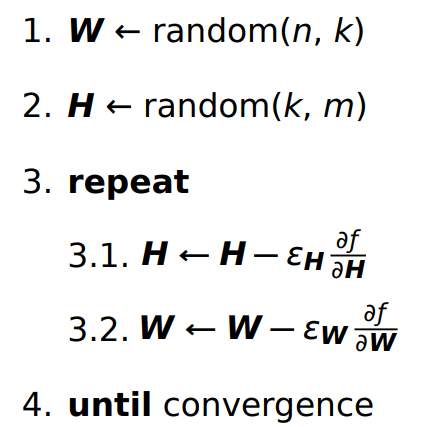

In [24]:
algorithm_nmf = NMF()
results_nmf = cross_validate(algorithm_nmf, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)


5. NormalPredictor

This algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. The prediction is generated from a normal distribution $n(\hat{\mu}, \hat{\sigma^2}$) where $\hat{\mu}$ and $\hat{\sigma^2}$ are estimated from the training data using Maximum Likelihood Estimation:
$$ \hat{\mu} = \frac{1}{|R_{train}|} \Sigma_{r_{ui} \in R_{train}} r_{ui}$$
$$ \hat{\sigma} = \sqrt{\Sigma_{r_{ui} \in R_{train}} \frac{(r_{ui} - \hat{\mu})^2}{|R_{train}|}}

In [25]:
algorithm_normal = NormalPredictor()
results_normal = cross_validate(algorithm_normal, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)


KNN-inspired algorithms for collaborative filtering is actually falling  under the broader umbrella of memory-based collaborative filtering as they **find "neighbours"** based on similariity and then make predictions based on **weighted metrices** of those neighbours.

6. KNNBaseline – KNN with a baseline predictor that accounts for user/item biases.
$$ \hat{r}_{ui} = b_{ui} + \frac{\Sigma_{v \in N^{k}_{i} (u)} sim(u, v) \cdot (r_{vi} - b_{ui})}{\Sigma_{v \in N^{k}_{i} (u)} sim(u, v)}$$

7. KNNBasic – A basic k-nearest neighbor model using user-user or item-item similarity.
$$ \hat{r}_{ui} = \frac{\Sigma_{v \in N^{k}_{i} (u)} sim(u, v) \cdot r_{vi}}{\Sigma_{v \in N^{k}_{i} (u)} sim(u, v)}$$

8. KNNWithMeans – KNN with rating means subtracted to normalize.
$$ \hat{r}_{ui} = \mu_u + \frac{\Sigma_{v \in N^{k}_{i} (u)} sim(u, v) \cdot (r_{vi} - \mu_v)}{\Sigma_{v \in N^{k}_{i} (u)} sim(u, v)}$$
9. KNNWithZScore – KNN using Z-score normalization for more standardized comparisons.
$$ \hat{r}_{ui} = \mu_u + \sigma_u \frac{\Sigma_{v \in N^{k}_{i} (u)} sim(u, v) \cdot (r_{vi} - \mu_v) / \sigma_v}{\Sigma_{v \in N^{k}_{i} (u)} sim(u, v)}$$

$k$: The (max) number of neighbours to take into account for aggregation 
\
$sim$: Similarity measures (eg. cosine similarity, Pearson, etc.)

<sub>Note: The equations shown here are of user-based. The item-based KNN predictions will have the same equation with different notations that represents item perspective.

For example, item-based KNNWithMeans Prediction:
$$ \hat{r}_{ui} = \mu_i + \frac{\Sigma_{j \in N^{k}_{u} (i)} sim(i, j) \cdot (r_{uj} - \mu_j)}{\Sigma_{j \in N^{k}_{u} (i)} sim(i, j)}$$
$\mu_i$: Average rating for item $i$
\
$N^{k}_{u} (i)$: k-neighbour items similar to $i$ which rated by user $u$
</sub>

In [26]:
algorithm_knnbase = KNNBaseline()
results_knnbase = cross_validate(algorithm_knnbase, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the msd similarity matrix...


MemoryError: Unable to allocate 7.65 TiB for an array with shape (1025364, 1025364) and data type float64

In [27]:
algorithm_knnbasic = KNNBasic()
results_knnbasic = cross_validate(algorithm_knnbasic, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the msd similarity matrix...


MemoryError: Unable to allocate 7.65 TiB for an array with shape (1025160, 1025160) and data type float64

In [28]:
algorithm_knnmeans = KNNWithMeans()
results_knnmeans = cross_validate(algorithm_knnmeans, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the msd similarity matrix...


MemoryError: Unable to allocate 7.65 TiB for an array with shape (1025061, 1025061) and data type float64

In [30]:
import gc
gc.collect()

2426

In [31]:
algorithm_knnz = KNNWithZScore()
results_knnz = cross_validate(algorithm_knnz, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the msd similarity matrix...


MemoryError: Unable to allocate 7.65 TiB for an array with shape (1025106, 1025106) and data type float64

9. BaselineOnly

The algorithm predicts ratings based on global averages and user/item biases.
$$ \hat{r_{ui}} = b_{ui} = \mu + b_u + b_i $$
If user $u$ is unknown, then the bias $b_u$ is assumed to be zero. The same applies for item $i$ with $b_i$.

In [32]:
algorithm_base = BaselineOnly()
results_base = cross_validate(algorithm_base, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


10. CoClustering

Co-clustering attempts to simultaneously group users and items into clusters, such that users in the same cluster have similar preferences; items in the same cluster are consumed similarly; and each user cluster-item cluster pair has a interaction score such as average rating. This gives a block matrix approximation of the original sparse user-item matrix.

The clustering criterion will be based on the types of co-clustering algorithm but basically the clusters are formed based on the interaction patterns in the matrix. For example, in Bregman Co-clustering, clusters are chosen to minimize the reconstruction error between the original matrix and co-cluster. Whereas spectral co-clustering uses eigen decomposition on the matrix to cluster both rows and columns by embedding them in a low-dimensional space.

After the clustering the users and items into groups, each co-cluster (user and item clusters) is computed their average rating and interaction for making prediction. In Surprise package, the prediction function is as follows:
$$ \hat{r_{ui}} =\bar{C_{ui}} + (\mu_u - \bar{C_u}) + (\mu_i - \bar{C_i})$$
where $\bar{C_{ui}}$ is the average rating of co-cluster $C_{ui}$, $\bar{C_u}$ is the average rating of $u$'s cluster and $\bar{C_i}$ is the average rating of $i$'s cluster.

In [33]:
algorithm_co = CoClustering()
results_co = cross_validate(algorithm_co, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

<!-- Resource limitatins -->
Some models especially the KNN series, are memory-intensive since they rely on computing and storing full user-user or item-item similarity matrices. Due to hardware constraints as I am running this notebook on a personal laptop with integrated graphics, some of the test results are not able to obtain. I will skip the outcome of some of the models that failed to be trained.

In [41]:
algorithms = [{
 "algorithm": SVD(),
 "results": results_svd
},
{
 "algorithm": SVDpp(),
 "results": results_svdpp
},
# {
#  "algorithm": SlopeOne(),
#  "results": results_slopeone
# },
{
 "algorithm": NMF(),
 "results": results_nmf
},
{
 "algorithm": NormalPredictor(),
 "results": results_normal
},
# {
#  "algorithm": KNNBaseline(),
#  "results": results_knnbase
# },
# {
#  "algorithm": KNNBasic(),
#  "results": results_knnbasic
# },
# {
#  "algorithm": KNNWithMeans(),
#  "results": results_knnmeans
# },
# {
#  "algorithm": KNNWithZScore(),
#  "results": results_knnz
# },
{
 "algorithm": BaselineOnly(),
 "results": results_base
},
{
 "algorithm": CoClustering(),
 "results": results_co
}]

In [65]:
# results = [results_svd, results_svdpp, results_slopeone, results_nmf, results_normal, results_knnbase, results_knnbasic, results_knnmeans, results_knnz, results_base, results_co]
performance = []
for algorithm in algorithms:
    # print(algorithm)
    algorithm_name = algorithm["algorithm"]
    result = algorithm["results"]
    try:
        # Get results & append algorithm name
        temp = pd.DataFrame.from_dict(result).mean(axis=0)
        temp = temp.append(pd.Series([str(algorithm_name).split(' ')[0].split('.')[-1]], index=['Algorithm']))
        performance.append(temp)
    except:
        continue

pd.DataFrame(performance).set_index('Algorithm').sort_values('test_rmse')   
    

C:\Users\User\AppData\Local\Temp\ipykernel_17120\3384193676.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = temp.append(pd.Series([str(algorithm_name).split(' ')[0].split('.')[-1]], index=['Algorithm']))
C:\Users\User\AppData\Local\Temp\ipykernel_17120\3384193676.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = temp.append(pd.Series([str(algorithm_name).split(' ')[0].split('.')[-1]], index=['Algorithm']))
C:\Users\User\AppData\Local\Temp\ipykernel_17120\3384193676.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = temp.append(pd.Series([str(algorithm_name).split(' ')[0].split('.')[-1]], index=['Algorithm']))
C:\Users\User\AppData\Local\Temp\ipykernel_17120\3384193676.py:10: FutureWarning: 

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
BaselineOnly,1.247770,0.983310,23.006065,3.750192
SVD,1.249327,0.976981,66.790846,5.647754
SVDpp,1.257014,0.975206,77.292214,12.455494
CoClustering,1.361463,1.003652,228.906520,7.848812
NMF,1.416433,1.119567,192.599280,6.249693
NormalPredictor,1.672139,1.259156,5.043494,2.774622


In [ ]:
# Save model for easy loading
for algorithm in algorithms:
    model = algorithm['algorithm']
    model_name = str(model).split(' ')[0].split('.')[-1]

    filename = f'model/{model_name}.pkl'
    pickle.dump(model, open(filename, 'wb'))

In [ ]:
# To load model
def load_model(model_path):
    loaded_model = pickle.load(open(model_path, 'rb'))
    return loaded_model

### Further reading 

Matrix Factorization: Yehuda Koren, Robert Bell, and Chris Volinsky. Matrix factorization techniques for recommender systems. 2009.